In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import pickle
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
def mean_absolute_percentage_error(actual, pred): 
    return np.mean(np.abs((actual - pred) / actual)) * 100

def evaluate_model(model_name, model, X, y):
    
    predictions = model.predict(X)

    MAE = mean_absolute_error(y, predictions)
    MAPE = mean_absolute_percentage_error(y, predictions)
    RMSE = mean_squared_error(y, predictions, squared = False)

    print('MAE for', model_name, ': %1.3f' % MAE)
    print('MAPE for', model_name, ': %1.3f' % MAPE)
    print('RMSE for', model_name, ': %1.3f' % RMSE)

    metrics_table = pd.DataFrame({'MAE' : [round(MAE, 3)], 'MAPE' : [round(MAPE, 3)], 'RMSE' : [round(RMSE, 3)]}, index = [model_name])
    
    return metrics_table

### Read in the data

In [4]:
data = pd.read_csv('../../data/laptops/laptops_cleaned.csv')
data.head()

,company,type,inches,cpu,gpu,op_sys,price_EUR,touch_screen,hd_category,ram,memory_SSD,memory_HDD,weight
0,Apple,Ultrabook,13.3,Intel Core i5,Other,Other,1339.69,0,QuadHD,8,128,0,1.37
1,Apple,Ultrabook,13.3,Intel Core i5,Intel HD,Other,898.94,0,HD,8,0,0,1.34
2,HP,Notebook,15.6,Intel Core i5,Intel HD,No OS,575.00,0,FullHD,8,256,0,1.86
3,Apple,Ultrabook,15.4,Intel Core i7,Other,Other,2537.45,0,QuadHD,16,512,0,1.83
4,Apple,Ultrabook,13.3,Intel Core i5,Other,Other,1803.60,0,QuadHD,8,256,0,1.37


### Dealing with input types

CatBoost can take categorical features as is, so I won't one-hot encode the data yet, instead, for most models I will separately one-hot encode the train and test sets, for CatBoost I'll just give the Regressor the features as string

In [5]:
y = data['price_EUR'].copy()
X = data.drop('price_EUR', 1).copy()

print('Shape of original data:', data.shape)
print('Shape of y:', y.shape)
print('Shape of X:', X.shape)

Shape of original data: (1298, 13)
Shape of y: (1298,)
Shape of X: (1298, 12)


### Train - Test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 20202020)

print('Shape of X train:', X_train.shape)
print('Shape of X test:', X_test.shape)
print('Shape of y train:', y_train.shape)
print('Shape of y test:', y_test.shape)

Shape of X train: (973, 12)
Shape of X test: (325, 12)
Shape of y train: (973,)
Shape of y test: (325,)


### One-hot encode categoricals

In [7]:
# Need original data for CatBoost

X_train_original = X_train.copy()
X_test_original = X_test.copy()

# One hot encode for other models

X_train = pd.get_dummies(X_train, columns = ['company', 'type', 'cpu', 'gpu', 'op_sys', 'hd_category'], prefix_sep = ' = ')
X_test = pd.get_dummies(X_test, columns = ['company', 'type', 'cpu', 'gpu', 'op_sys', 'hd_category'], prefix_sep = ' = ')

In [8]:
print('Original amount of Xs:', X_train_original.shape[1])
print('Column # with one-hot encoding:', X_train.shape[1])

Original amount of Xs: 12
Column # with one-hot encoding: 44


### Scale X train and transform X test

For distance-based ML models data should be scaled for faster convergence, therefore I will use the StandardScaler() function to transform my features into variables with E(x) = 0 and Std(x) = 1. This will also speed up linreg for example, but won't have an effect on performance

In [9]:
SS = StandardScaler()

X_train_scaled = SS.fit_transform(X_train)
X_test_scaled = SS.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

# Applying the different ML models

### 1. DummyRegressor to compare results against

Predicting the median

In [11]:
dummy = DummyRegressor(strategy = 'median')
dummy.fit(X_train_scaled, y_train)

DummyRegressor(constant=None, quantile=None, strategy='median')

In [12]:
dummy_median = evaluate_model('DummyRegressorMedian', dummy, X_test_scaled, y_test)

MAE for DummyRegressorMedian : 490.824
MAPE for DummyRegressorMedian : 58.169
RMSE for DummyRegressorMedian : 667.912


Predicting the 25% percentile

In [13]:
dummy = DummyRegressor(strategy = 'quantile', quantile = 0.25)
dummy.fit(X_train_scaled, y_train)

DummyRegressor(constant=None, quantile=0.25, strategy='quantile')

In [14]:
dummy_quantile = evaluate_model('DummyRegressorQuantile', dummy, X_test_scaled, y_test)

MAE for DummyRegressorQuantile : 579.728
MAPE for DummyRegressorQuantile : 46.463
RMSE for DummyRegressorQuantile : 826.321


Concat results

In [15]:
model_comparison = pd.concat([dummy_median, dummy_quantile], 0)
model_comparison.head()

,MAE,MAPE,RMSE
DummyRegressorMedian,490.824,58.169,667.912
DummyRegressorQuantile,579.728,46.463,826.321


### 2. Simple linear regression

In [16]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
linreg = evaluate_model('LinearRegression', lr, X_test_scaled, y_test)

MAE for LinearRegression : 209.458
MAPE for LinearRegression : 21.858
RMSE for LinearRegression : 285.492


In [18]:
model_comparison = pd.concat([model_comparison, linreg], 0)
model_comparison.head()

,MAE,MAPE,RMSE
DummyRegressorMedian,490.824,58.169,667.912
DummyRegressorQuantile,579.728,46.463,826.321
LinearRegression,209.458,21.858,285.492


### 3. Regularized / penalized regressions
#### 1. Ridge Regression

In [19]:
ridge_params = {'alpha' : np.linspace(46, 50, 31)}

ridge = Ridge(random_state = 20202020)

GRID_RIDGE = GridSearchCV(ridge, param_grid = ridge_params, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_RIDGE.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False,
                             random_state=20202020, solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([46.        , 46.13333333, 46.26666667, 46.4       , 46.53333333,
       46.66666667, 46.8       , 46.93333333, 47.06666667, 47.2       ,
       47.33333333, 47.46666667, 47.6       , 47.73333333, 47.86666667,
       48.        , 48.13333333, 48.26666667, 48.4       , 48.53333333,
       48.66666667, 48.8       , 48.93333333, 49.06666667, 49.2       ,
       49.33333333, 49.46666667, 49.6       , 49.73333333, 49.86666667,
       50.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [20]:
GRID_RIDGE.best_params_

{'alpha': 47.733333333333334}

In [21]:
ridgereg = evaluate_model('RidgeRegression', GRID_RIDGE.best_estimator_, X_test_scaled, y_test)

MAE for RidgeRegression : 209.445
MAPE for RidgeRegression : 21.830
RMSE for RidgeRegression : 285.552


In [22]:
model_comparison = pd.concat([model_comparison, ridgereg], 0)
model_comparison.head()

,MAE,MAPE,RMSE
DummyRegressorMedian,490.824,58.169,667.912
DummyRegressorQuantile,579.728,46.463,826.321
LinearRegression,209.458,21.858,285.492
RidgeRegression,209.445,21.830,285.552


#### 2. LASSO Regression

In [23]:
LASSO_params = {'alpha' : np.linspace(1.8, 2, 21)}

lasso = Lasso(random_state = 20202020)

GRID_LASSO = GridSearchCV(lasso, param_grid = LASSO_params, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_LASSO.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=20202020,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 ,
       1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.  ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [24]:
GRID_LASSO.best_params_

{'alpha': 1.9100000000000001}

In [25]:
lassoreg = evaluate_model('LassoRegression', GRID_LASSO.best_estimator_, X_test_scaled, y_test)

MAE for LassoRegression : 209.255
MAPE for LassoRegression : 21.883
RMSE for LassoRegression : 284.870


In [26]:
model_comparison = pd.concat([model_comparison, lassoreg], 0)
model_comparison.head()

,MAE,MAPE,RMSE
DummyRegressorMedian,490.824,58.169,667.912
DummyRegressorQuantile,579.728,46.463,826.321
LinearRegression,209.458,21.858,285.492
RidgeRegression,209.445,21.830,285.552
LassoRegression,209.255,21.883,284.870


#### 3. Elastic Net Regression

In [27]:
ElasticNet_params = {'alpha' : np.linspace(1.3, 1.5, 21),
                     'l1_ratio' : np.linspace(0.95, 1, 21)} 

elasticnet = ElasticNet(random_state = 20202020)

GRID_EN = GridSearchCV(elasticnet, param_grid = ElasticNet_params, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_EN.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=20202020, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 ,
       1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 ]),
                         'l1_ratio': array([0.95  , 0.9525, 0.955 , 0.9575, 0.96  , 0.9625, 0.965 , 0.9675,
       0.97  , 0.9725, 0.975 , 0.9775, 0.98  , 0.9825, 0.985 , 0.9875,
       0.99  , 0.9925, 0.995 , 0.9975, 1.    ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [28]:
GRID_EN.best_params_

{'alpha': 1.4100000000000001, 'l1_ratio': 0.975}

In [29]:
elasticnetreg = evaluate_model('ElasticNetRegression', GRID_EN.best_estimator_, X_test_scaled, y_test)

MAE for ElasticNetRegression : 209.729
MAPE for ElasticNetRegression : 21.880
RMSE for ElasticNetRegression : 285.417


In [30]:
model_comparison = pd.concat([model_comparison, elasticnetreg], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,490.824,58.169,667.912
DummyRegressorQuantile,579.728,46.463,826.321
LinearRegression,209.458,21.858,285.492
RidgeRegression,209.445,21.830,285.552
LassoRegression,209.255,21.883,284.870
ElasticNetRegression,209.729,21.880,285.417


### 4. Nearest neighbors methods

#### 1. k-nearest neighbors

In [31]:
knn_params = {'p' : [1, 2], # manhattan / euclidean
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['ball_tree', 'kd_tree', 'auto'],
              'n_neighbors' : [7, 8, 9, 10, 11, 12]}

KNN = KNeighborsRegressor()

GRID_KNN = GridSearchCV(KNN, param_grid = knn_params, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_KNN.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'auto'],
                         'n_neighbors': [7, 8, 9, 10, 11, 12], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [32]:
GRID_KNN.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}

In [33]:
knnreg = evaluate_model('KNN', GRID_KNN.best_estimator_, X_test_scaled, y_test)

MAE for KNN : 206.903
MAPE for KNN : 19.981
RMSE for KNN : 300.964


In [34]:
model_comparison = pd.concat([model_comparison, knnreg], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,490.824,58.169,667.912
DummyRegressorQuantile,579.728,46.463,826.321
LinearRegression,209.458,21.858,285.492
RidgeRegression,209.445,21.830,285.552
LassoRegression,209.255,21.883,284.870
ElasticNetRegression,209.729,21.880,285.417
KNN,206.903,19.981,300.964


#### 2. Radius neighbors

In [48]:
rnn_params = {'p' : [2], # manhattan / euclidean
              'weights' : ['distance', 'uniform'], # uniform / distance
              'radius' : [20, 21, 22]}

RNN = RadiusNeighborsRegressor()

GRID_RNN = GridSearchCV(RNN, param_grid = rnn_params, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_RNN.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RadiusNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                metric='minkowski',
                                                metric_params=None, n_jobs=None,
                                                p=2, radius=1.0,
                                                weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'p': [2], 'radius': [20, 21, 22],
                         'weights': ['distance', 'uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [49]:
GRID_RNN.best_params_

{'p': 2, 'radius': 21, 'weights': 'distance'}

In [50]:
rnnreg = evaluate_model('RadiusNN', GRID_RNN.best_estimator_, X_test_scaled, y_test)

MAE for RadiusNN : 428.827
MAPE for RadiusNN : 55.660
RMSE for RadiusNN : 591.425


In [51]:
model_comparison = pd.concat([model_comparison, rnnreg], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,490.824,58.169,667.912
DummyRegressorQuantile,579.728,46.463,826.321
LinearRegression,209.458,21.858,285.492
RidgeRegression,209.445,21.830,285.552
LassoRegression,209.255,21.883,284.870
ElasticNetRegression,209.729,21.880,285.417
KNN,206.903,19.981,300.964
RadiusNN,428.827,55.660,591.425


### 5. Support Vector Machines

#### 1. Linear kernel

In [67]:
svr_lin_params = {'C' : [840, 850, 860]}

svr = SVR(kernel = 'linear')

GRID_SVM = GridSearchCV(svr, param_grid = svr_lin_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_SVM.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='linear',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1, param_grid={'C': [840, 850, 860]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [68]:
GRID_SVM.best_params_

{'C': 850}

In [69]:
svmlin = evaluate_model('SVMLinear', GRID_SVM.best_estimator_, X_test_scaled, y_test)

MAE for SVMLinear : 206.003
MAPE for SVMLinear : 20.424
RMSE for SVMLinear : 288.413


In [70]:
model_comparison = pd.concat([model_comparison, svmlin], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,490.824,58.169,667.912
DummyRegressorQuantile,579.728,46.463,826.321
LinearRegression,209.458,21.858,285.492
RidgeRegression,209.445,21.830,285.552
LassoRegression,209.255,21.883,284.870
ElasticNetRegression,209.729,21.880,285.417
KNN,206.903,19.981,300.964
RadiusNN,428.827,55.660,591.425
SVMLinear,206.003,20.424,288.413


#### 2. Polynomial kernel

In [92]:
svr_poly_params = {'C' : [775, 780, 785],
                   'degree' : [2, 3, 4, 5]}

svr = SVR(kernel = 'poly')

GRID_SVM = GridSearchCV(svr, param_grid = svr_poly_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_SVM.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [775, 780, 785], 'degree': [2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [93]:
GRID_SVM.best_params_

{'C': 780, 'degree': 3}

In [94]:
svmpoly = evaluate_model('SVMPolynomial', GRID_SVM.best_estimator_, X_test_scaled, y_test)

MAE for SVMPolynomial : 198.942
MAPE for SVMPolynomial : 19.103
RMSE for SVMPolynomial : 299.185


In [98]:
model_comparison = pd.concat([model_comparison, svmpoly], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,490.824,58.169,667.912
DummyRegressorQuantile,579.728,46.463,826.321
LinearRegression,209.458,21.858,285.492
RidgeRegression,209.445,21.830,285.552
LassoRegression,209.255,21.883,284.870
ElasticNetRegression,209.729,21.880,285.417
KNN,206.903,19.981,300.964
RadiusNN,428.827,55.660,591.425
SVMLinear,206.003,20.424,288.413
SVMPolynomial,198.942,19.103,299.185


#### 3. Radial Basis Function kernel

In [129]:
svr_rbf_params = {'C' : [5000],
                  'gamma' : np.linspace(0.0045, 0.0055, 10)}

svr = SVR(kernel = 'rbf')

GRID_SVM = GridSearchCV(svr, param_grid = svr_rbf_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_SVM.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [5000],
                         'gamma': array([0.0045    , 0.00461111, 0.00472222, 0.00483333, 0.00494444,
       0.00505556, 0.00516667, 0.00527778, 0.00538889, 0.0055    ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [130]:
GRID_SVM.best_params_

{'C': 5000, 'gamma': 0.005166666666666667}

In [131]:
svmrbf = evaluate_model('SVMRadialBasis', GRID_SVM.best_estimator_, X_test_scaled, y_test)

MAE for SVMRadialBasis : 177.794
MAPE for SVMRadialBasis : 16.373
RMSE for SVMRadialBasis : 263.030


In [132]:
model_comparison = pd.concat([model_comparison, svmrbf], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,490.824,58.169,667.912
DummyRegressorQuantile,579.728,46.463,826.321
LinearRegression,209.458,21.858,285.492
RidgeRegression,209.445,21.830,285.552
LassoRegression,209.255,21.883,284.870
ElasticNetRegression,209.729,21.880,285.417
KNN,206.903,19.981,300.964
RadiusNN,428.827,55.660,591.425
SVMLinear,206.003,20.424,288.413
SVMPolynomial,198.942,19.103,299.185


### 6. Decision Tree

In [151]:
DT_params = {'max_depth' : [7, 9, 11],
             'min_samples_split' : [25],
             'min_samples_leaf' : [3, 4],
             'max_features' : [1/3, 1/2, 2/3, 1]}

DT = DecisionTreeRegressor(random_state = 20202020)

GRID_DT = GridSearchCV(DT, param_grid = DT_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_DT.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=20202020,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [7, 9, 11],
                         'max_features': [0.3333333333333333, 0.5,
                                    

In [152]:
GRID_DT.best_params_

{'max_depth': 9,
 'max_features': 0.5,
 'min_samples_leaf': 3,
 'min_samples_split': 25}

In [153]:
dtreg = evaluate_model('DecisionTree', GRID_DT.best_estimator_, X_test, y_test)

MAE for DecisionTree : 209.231
MAPE for DecisionTree : 20.130
RMSE for DecisionTree : 292.816


In [154]:
model_comparison = pd.concat([model_comparison, dtreg], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,490.824,58.169,667.912
DummyRegressorQuantile,579.728,46.463,826.321
LinearRegression,209.458,21.858,285.492
RidgeRegression,209.445,21.830,285.552
LassoRegression,209.255,21.883,284.870
ElasticNetRegression,209.729,21.880,285.417
KNN,206.903,19.981,300.964
RadiusNN,428.827,55.660,591.425
SVMLinear,206.003,20.424,288.413
SVMPolynomial,198.942,19.103,299.185


We can actually visualize our decision tree

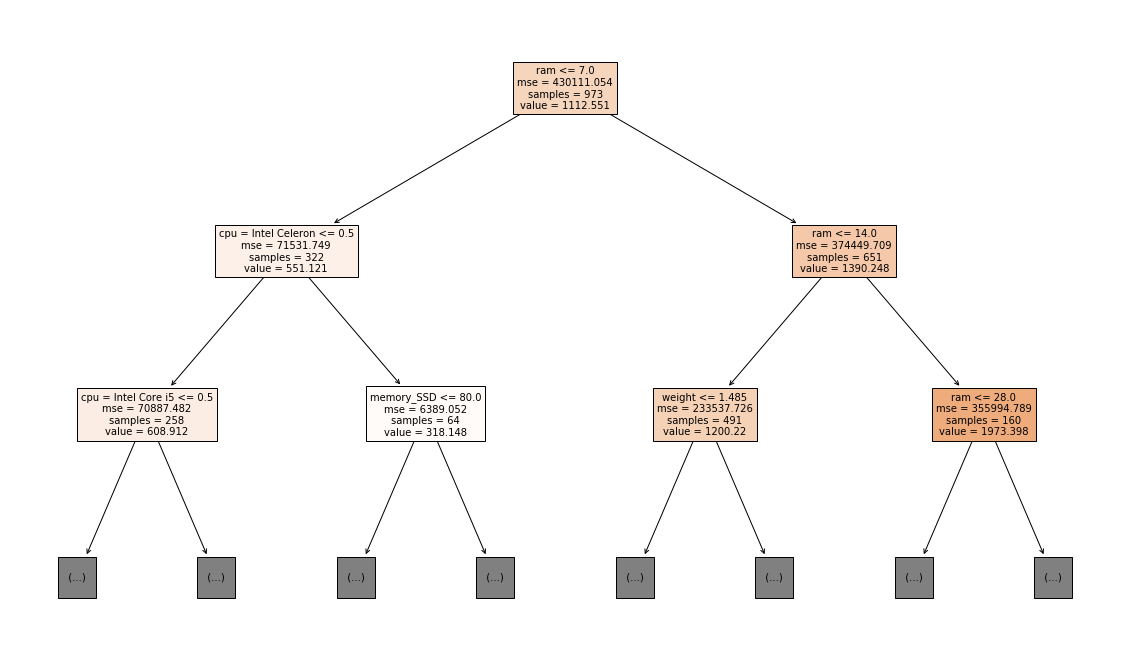

In [156]:
plt.figure(figsize = (20, 12))
plot_tree(GRID_DT.best_estimator_, feature_names = X_train_scaled.columns, 
          filled = True, fontsize = 10, max_depth = 2)
plt.show()

### 7. Simple Trees Ensembles

#### 1. Random Forest

In [ ]:
RF_params = {'max_depth' : [11, 13, 15, 17],
             'min_samples_split' : [9, 11, 13, 15],
             'min_samples_leaf' : [1, 2, 3, 5],
             'max_features' : [1/2, 2/3, 3/4],
             'n_estimators' : [100, 150, 200]}

RF = RandomForestRegressor(random_state = 20202020)

GRID_RF = GridSearchCV(RF, param_grid = RF_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_RF.fit(X_train, y_train)

In [94]:
GRID_RF.best_params_

{'max_depth': 19,
 'max_features': 0.8,
 'min_samples_leaf': 1,
 'min_samples_split': 11,
 'n_estimators': 250}

In [95]:
rfreg = evaluate_model('RandomForest', GRID_RF.best_estimator_, X_test, y_test)

MAE for RandomForest : 277.616
MAPE for RandomForest : 7.809
RMSE for RandomForest : 534.131


In [97]:
# 19, 0.8, 1, 11 --> RMSE 534

model_comparison = pd.concat([model_comparison, rfreg], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,2806.394,110.422,4258.833
DummyRegressorQuantile,3105.765,60.473,4964.068
LinearRegression,802.058,45.038,1143.712
RidgeRegression,803.104,45.201,1143.745
LassoRegression,803.087,45.197,1143.747
ElasticNetRegression,803.089,45.198,1143.747
KNN,482.132,16.075,956.333
RadiusNN,1735.694,85.742,2806.814
SVMLinear,740.706,32.642,1269.544
SVMPolynomial,321.621,9.542,597.217


#### 2. AdaBoost

In [98]:
Ada_params = {'learning_rate' : [1.5],
              'loss' : ['square'], #'linear'
              'n_estimators' : [50, 75, 100]}

Ada = AdaBoostRegressor(random_state = 20202020)

GRID_Ada = GridSearchCV(Ada, param_grid = Ada_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_Ada.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=AdaBoostRegressor(random_state=20202020),
             n_jobs=-1,
             param_grid={'learning_rate': [1.5], 'loss': ['square'],
                         'n_estimators': [50, 75, 100]},
             scoring='neg_root_mean_squared_error')

In [99]:
GRID_Ada.best_params_

{'learning_rate': 1.5, 'loss': 'square', 'n_estimators': 100}

In [100]:
adaboost = evaluate_model('AdaBoost', GRID_Ada.best_estimator_, X_test, y_test)

MAE for AdaBoost : 1044.361
MAPE for AdaBoost : 45.476
RMSE for AdaBoost : 1355.758


In [101]:
model_comparison = pd.concat([model_comparison, adaboost], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,2806.394,110.422,4258.833
DummyRegressorQuantile,3105.765,60.473,4964.068
LinearRegression,802.058,45.038,1143.712
RidgeRegression,803.104,45.201,1143.745
LassoRegression,803.087,45.197,1143.747
ElasticNetRegression,803.089,45.198,1143.747
KNN,482.132,16.075,956.333
RadiusNN,1735.694,85.742,2806.814
SVMLinear,740.706,32.642,1269.544
SVMPolynomial,321.621,9.542,597.217


#### 3. Gradient Boosting Machine

In [83]:
GBM_params = {'learning_rate' : [0.05],
              'subsample' : [0.8],
              'max_features' : [2/3],
              'max_depth' : [11],
              'min_samples_split' : [25],
              'min_samples_leaf' : [7],
              'n_estimators' : [100, 150, 200, 250]}

GBM = GradientBoostingRegressor(random_state = 20202020)

GRID_GBM = GridSearchCV(GBM, param_grid = GBM_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_GBM.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=20202020),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': [11],
                         'max_features': [0.6666666666666666],
                         'min_samples_leaf': [7], 'min_samples_split': [25],
                         'n_estimators': [100, 150, 200, 250],
                         'subsample': [0.8]},
             scoring='neg_root_mean_squared_error')

In [84]:
GRID_GBM.best_params_

{'learning_rate': 0.05,
 'max_depth': 11,
 'max_features': 0.6666666666666666,
 'min_samples_leaf': 7,
 'min_samples_split': 25,
 'n_estimators': 150,
 'subsample': 0.8}

In [85]:
gradboost = evaluate_model('GradientBoosting', GRID_GBM.best_estimator_, X_test, y_test)

MAE for GradientBoosting : 270.413
MAPE for GradientBoosting : 7.443
RMSE for GradientBoosting : 521.643


In [102]:
model_comparison = pd.concat([model_comparison, gradboost], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,2806.394,110.422,4258.833
DummyRegressorQuantile,3105.765,60.473,4964.068
LinearRegression,802.058,45.038,1143.712
RidgeRegression,803.104,45.201,1143.745
LassoRegression,803.087,45.197,1143.747
ElasticNetRegression,803.089,45.198,1143.747
KNN,482.132,16.075,956.333
RadiusNN,1735.694,85.742,2806.814
SVMLinear,740.706,32.642,1269.544
SVMPolynomial,321.621,9.542,597.217


In [70]:
pkl_filename = "SimpleGBM.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(GRID_GBM.best_estimator_, file)

### 8. eXtreme Gradient Boosting Machine

In [79]:
start = time.time()

XGB_params = {'eta' : [0.075],
              'gamma' : [0.9],
              'subsample' : [3/4],
              'colsample_bytree' : [3/4],
              'colsample_bynode' : [1],
              'max_depth' : [8],
              'min_child_weight' : [3],
              'n_estimators' : [150]}

XGB = xgb.XGBRegressor(random_state = 20202020, verbosity = 0,
                       objective = 'reg:squarederror', eval_metric = 'rmse')

GRID_XGB = GridSearchCV(XGB, param_grid = XGB_params, cv = 3, scoring = 'neg_root_mean_squared_error')

GRID_XGB.fit(X_train, y_train)

print(time.time() - start)

70.79944610595703


In [80]:
GRID_XGB.best_params_

{'colsample_bynode': 1,
 'colsample_bytree': 0.75,
 'eta': 0.075,
 'gamma': 0.9,
 'max_depth': 8,
 'min_child_weight': 3,
 'n_estimators': 150,
 'subsample': 0.75}

In [81]:
xgboost = evaluate_model('xgBoost', GRID_XGB.best_estimator_, X_test, y_test)

MAE for xgBoost : 281.573
MAPE for xgBoost : 8.268
RMSE for xgBoost : 532.469


In [103]:
model_comparison = pd.concat([model_comparison, xgboost], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,2806.394,110.422,4258.833
DummyRegressorQuantile,3105.765,60.473,4964.068
LinearRegression,802.058,45.038,1143.712
RidgeRegression,803.104,45.201,1143.745
LassoRegression,803.087,45.197,1143.747
ElasticNetRegression,803.089,45.198,1143.747
KNN,482.132,16.075,956.333
RadiusNN,1735.694,85.742,2806.814
SVMLinear,740.706,32.642,1269.544
SVMPolynomial,321.621,9.542,597.217


### 9. Light Gradient Boosting Machine

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor

In [188]:
start = time.time()
print("Started at", str(time.ctime(int(start))))

LGB_params = {'boosting_type' : ['goss'],
              'learning_rate' : [0.075],
              'num_leaves' : [40, 45],
              'min_child_samples' : [5],
              'max_depth' : [-1],
              'subsample' : [0.4, 0.5],
              'colsample_bytree' : [0.9],
              'n_estimators' : [155, 165, 175]}

LGB = lgb.LGBMRegressor(random_state = 20202020,
                        objective = 'regression', application = 'root_mean_squared_error', metric = 'rmse')

GRID_LGB = GridSearchCV(LGB, param_grid = LGB_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_LGB.fit(X_train, y_train)

print("Ended at", str(time.ctime(int(time.time()))))
print(time.time() - start)

Started at Mon Nov 30 09:48:50 2020
Ended at Mon Nov 30 09:49:04 2020
14.378001928329468


In [189]:
GRID_LGB.best_params_

{'boosting_type': 'goss',
 'colsample_bytree': 0.9,
 'learning_rate': 0.075,
 'max_depth': -1,
 'min_child_samples': 5,
 'n_estimators': 165,
 'num_leaves': 45,
 'subsample': 0.4}

In [190]:
lightgbm = evaluate_model('LightGBM', GRID_LGB.best_estimator_, X_test, y_test)

MAE for LightGBM : 279.798
MAPE for LightGBM : 8.182
RMSE for LightGBM : 524.610


In [143]:
model_comparison = pd.concat([model_comparison, lightgbm], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,2806.394,110.422,4258.833
DummyRegressorQuantile,3105.765,60.473,4964.068
LinearRegression,802.058,45.038,1143.712
RidgeRegression,803.104,45.201,1143.745
LassoRegression,803.087,45.197,1143.747
ElasticNetRegression,803.089,45.198,1143.747
KNN,482.132,16.075,956.333
RadiusNN,1735.694,85.742,2806.814
SVMLinear,740.706,32.642,1269.544
SVMPolynomial,321.621,9.542,597.217


In [194]:
pkl_filename = "LightGBM.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(GRID_LGB.best_estimator_, file)

### 10. CatBoost - Categorical Boosting Machine

https://catboost.ai/docs/concepts/python-reference_parameters-list.html

In [180]:
start = time.time()
print("Started at", str(time.ctime(int(start))))

cat_params = {'learning_rate': [0.075],
              'l2_leaf_reg': [0.15],
              'subsample': [0.75],
              'rsm' : [0.85],
              'depth': [15],
              'grow_policy': ['Lossguide'], #'SymmetricTree', 'Depthwise'
              'min_data_in_leaf' : [1], 
              'max_leaves' : [40],
              'iterations' : [300, 325, 350, 375, 400, 425]}

cat = CatBoostRegressor(random_state = 20202020, verbose = 0,
                        eval_metric = 'RMSE', custom_metric = 'RMSE', objective = 'RMSE',
                        cat_features = ['cut', 'color', 'clarity'])

GRID_cat = GridSearchCV(cat, param_grid = cat_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

GRID_cat.fit(X_train_original, y_train)

print("Ended at", str(time.ctime(int(time.time()))))
print(time.time() - start)

Started at Mon Nov 30 08:50:10 2020
Ended at Mon Nov 30 09:05:56 2020
946.121114730835


In [181]:
GRID_cat.best_params_

{'depth': 15,
 'grow_policy': 'Lossguide',
 'iterations': 325,
 'l2_leaf_reg': 0.15,
 'learning_rate': 0.075,
 'max_leaves': 40,
 'min_data_in_leaf': 1,
 'rsm': 0.85,
 'subsample': 0.75}

In [182]:
catboost = evaluate_model('CatBoost', GRID_cat.best_estimator_, X_test_original, y_test)

MAE for CatBoost : 275.909
MAPE for CatBoost : 8.113
RMSE for CatBoost : 520.819


In [183]:
model_comparison = pd.concat([model_comparison, catboost], 0)
model_comparison

,MAE,MAPE,RMSE
DummyRegressorMedian,2806.394,110.422,4258.833
DummyRegressorQuantile,3105.765,60.473,4964.068
LinearRegression,802.058,45.038,1143.712
RidgeRegression,803.104,45.201,1143.745
LassoRegression,803.087,45.197,1143.747
ElasticNetRegression,803.089,45.198,1143.747
KNN,482.132,16.075,956.333
RadiusNN,1735.694,85.742,2806.814
SVMLinear,740.706,32.642,1269.544
SVMPolynomial,321.621,9.542,597.217


In [184]:
pkl_filename = "CatBoost.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(GRID_cat.best_estimator_, file)

### Save datasets for evaluation

In [193]:
X_train_original.to_csv('../data/X_train_original.csv', index = False)
X_test_original.to_csv('../data/X_test_original.csv', index = False)
X_train.to_csv('../data/X_train.csv', index = False)
X_test.to_csv('../data/X_test.csv', index = False)
y_train.to_csv('../data/y_train.csv', index = False)
y_test.to_csv('../data/y_test.csv', index = False)

In [191]:
#pd.read_csv('../data/model_comparison.csv', index_col=0)
model_comparison.to_csv('../data/model_comparison.csv')